##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# On-device recommendation with TensorFlow Lite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/lite/examples/recommendation/ml/ondevice_recommendation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/lite/examples/recommendation/ml/ondevice_recommendation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Overview

This code base provides an adaptive framework to train and serve on-device recommendation
model. This approach personalizes recommendations by leveraging on-device data,
and protects user privacy without having user data leave device.

This Notebook shows an end-to-end example that

*   prepares sequential training data 
*   trains neural-network model with various encoding techniques
*   exports the model to TensorFlow Lite
*   integrates in on-device ML applications to generate personalized recommendations.

With this example, we demonstrate the approach with public
[movielens](https://grouplens.org/datasets/movielens/) dataset, but you could
adapt the data processing script for your dataset and train your own
recommendation model.

# Prerequisites

To run this example, please clone the source code from github [repo](https://github.com/tensorflow/examples/tree/master/lite/examples/recommendation/ml), install required packages.

In [ ]:
!git clone https://github.com/tensorflow/examples
%cd examples/lite/examples/recommendation/ml/
!pip install -r requirements.txt

# Model

We leverage a dual-encoder model architecture, with context-encoder to encode
sequential user history and label-encoder to encode predicted recommendation
candidate. Similarity between context and label encodings is used to represent
the likeliness predicted candidate meets user's needs.

Three different sequential user history encoding techniques are provided with
this code base:

* **Bag of words encoder (BOW)**: averaging user activities' embeddings without
considering context order.
* **Convolutional neural-network encoder (CNN)**: applying multiple layers of
convolutional neural-network to generate context encoding.
* **Recurrent neural-network encoder (RNN)**: applying recurrent neural network
(LSTM in this example) to understand context sequence.

In terms of user sequence modeling, we consider there are two approaches in general:
* **Id-based**: putting all recommendation candidates in an embedding space to understand similarities of items. The embeddings are keyed with item Ids in the item vocabulary. Hence we call it id-based approach.
* **Feature-based**: use more features of user activities, not only the item ids. For instance, movie genre and movie rating for movie recommendation. The model will understand the features and learns the way to understand user.

This framework code base supports both id-based and feature-based recommendation models, with a configurable way.



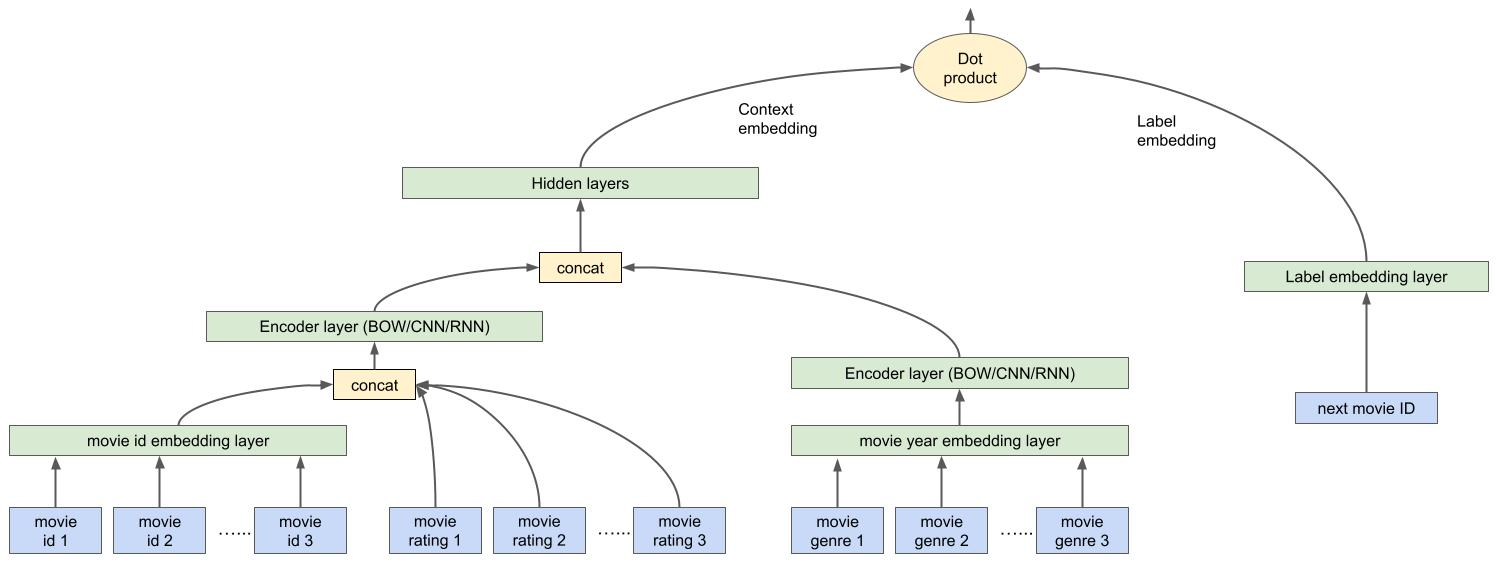

# Data Adaptivity

The framework can support model training or customization with various kinds of data, for which we provide the way to configurate the input data and encoder architecture.

With the input config, you can specify the input features' information, such as data type, shapde, vocab, embedding dimension. You can also freely group features in a feature group to encode together, for instance movie_id and movie rating in above diagram.  We support 3 feature types INT/STRING/FLOAT, for string and integer categorical features we will map them in embedding spaces, for float feature we suggest to concatenate directly together with other features' embeddings.

Please check out the step-to-step example session below for more details about setting up the input config.

# Training Data Preparation

This notebook makes use of public dataset [movielens](https://grouplens.org/datasets/movielens/) to demonstrate training of on-device recommendation model.

## Examples Generation
The examples generation process performs the following steps:


*   Downloads [movielens](https://grouplens.org/datasets/movielens/) dataset
*   Groups movie rating records by user, and orders per-user movie rating records by timestamp.
*   Generates TensorFlow examples with features: 1) `context_movie_id`: 
time-ordered sequential movie IDs 2) `context_movie_rating`: time-ordered sequential rating numbers 3) `context_movie_genre`: time-ordered sequential movie genres 4) `context_movie_year`: time-ordered sequential movie years. 5) `label_movie_id`: the next movie ID user rated.

There's case that one user activity will have multiple values for a single feature. For example, the movie genre feature in movielens dataset, each movie can have multiple genres. For this case, we suggest to concatenate all movies' genres for the activity sequence. Let's look at one example, if the user activity sequence is
```
Star Wars: Episode IV - A New Hope (1977), Genres: Action|Adventure|Fantasy
Terminator 2: Judgment Day (1991), Genres: Action|Sci-Fi|Thriller
Jurassic Park (1993), Genres: Action|Adventure|Sci-Fi
```
The context_movie_genre feature will be
```
"Action, Adventure, Fantasy, Action, Sci-Fi, Thriller, Action, Adventure, Sci-Fi"
```
Since TFLite input tensors should be fixed length, so we suggest to pad features to fixed length.

## Vocabularies Generation
For String and Integer type features, we would suggest to create an embedding space for each of them, for which vocabularies will be needed. This framework supports txt file based vocabulary setup, for which you can puch vocab iten line-by-line in a txt file. And in the training input pipeline vocabularies will be formed as:

```
tf.lookup.StaticVocabularyTable(
      tf.lookup.TextFileInitializer(
          vocab_path,
          key_dtype=key_type,
          key_index=tf.lookup.TextFileIndex.WHOLE_LINE,
          value_dtype=tf.int64,
          value_index=tf.lookup.TextFileIndex.LINE_NUMBER,
          delimiter='\t'),
      num_oov_buckets)
```
And vocab_path is the path to the genreated vocabulary txt file.

The `data/example_generation_movielens.py` script, generates vocabularies with "--build_vocabs" set as true.

## Try out data preparation
Please try out the movielens training examples and vocabs generation script below.

Note: If you would like to use your own data, please adapt the data processing script for your specific case.

In [ ]:
!python -m data.example_generation_movielens \
  --data_dir=data/raw \
  --output_dir=data/examples \
  --min_timeline_length=3 \
  --max_context_length=10 \
  --max_context_movie_genre_length=32 \
  --min_rating=2 \
  --train_data_fraction=0.9 \
  --build_vocabs=True

Raw movielens ratings.dat data is in the following format:
UserID::MovieID::Rating::Timestamp

*   UserIDs range between 1 and 6040
*   MovieIDs range between 1 and 3952
*   Ratings are made on a 5-star scale (whole-star ratings only)
*   Timestamp is represented in seconds since the epoch as returned by time(2)
*   Each user has at least 20 ratings

Ref:[movielens readme.txt](http://files.grouplens.org/datasets/movielens/ml-1m-README.txt)

In this example, we consider each rating as a movie watch by the users, and construct user movie watch history with rated movie IDs ordering by time.

Sample generated training example with max user history as 10:
```
0 : {   # (tensorflow.Example)
  features: {   # (tensorflow.Features)
    feature: {
      key  : "context_movie_id"
      value: {
        int64_list: {
          value: [ 3476, 3264, 2120, 1717, 382, 1644, 2328, 2461, 2064, 3679 ]
        }
      }
    }
    feature: {
      key  : "context_movie_year"
      value: {
        int64_list: {
          value: [ 1990, 1992, 1993, 1997, 1994, 1997, 1998, 1990, 1989, 1981 ]
        }
      }
    }
    feature: {
      key  : "context_movie_genre"
      value: {
        bytes_list: {
          value: [ "Horror", "Mystery", "Thriller", "Comedy", "Horror", "Drama", "Horror", "Horror", "Thriller", "Drama", "Horror", "Horror", "Mystery", "Thriller", "Horror", "Horror", "Comedy", "Documentary", "Documentary", "UNK", "UNK", "UNK", "UNK", "UNK", "UNK", "UNK", "UNK", "UNK", "UNK", "UNK", "UNK", "UNK" ]
        }
      }
    }
    feature: {
      key  : "context_movie_rating"
      value: {
        float_list: {
          value: [ 4.0, 4.0, 3.0, 1.0, 3.0, 3.0, 1.0, 4.0, 3.0, 4.0 ]
        }
      }
    }
    feature: {
      key  : "label_movie_id"
      value: {
        int64_list: {
          value: [ 1361 ]
        }
      }
    }
  }
}
```

# Model Configuration

##Input Configuration

Trainer code will prepare tf datasets and set up model according to input config. You can configurate the following:

*   Feature: name, data type, feature length, vocab name, vocab size, embedding dimension.
*   Feature group: features to encode together, encoder type.
*   Global feature groups: global features, e.g. user age, profession etc.
*   Activity feature groups: features to represent activities.
*   Label feature: the feature used as label.

Both input data processing and model architecture setup will be based on the input configuration.

Please check example input config with command below:

In [ ]:
!cat configs/sample_input_config.pbtxt

# Train model

The training launcher script uses TensorFlow keras compile/fit APIs and performs
the following steps to kick off training and evaluation process:

*   Set up both train and eval dataset input function.
*   Construct keras model according to provided configs, please refer to sample.config file in the source code to config your model architecture, such as embedding dimension, convolutional neural network params, LSTM units etc.
*   Setup loss function. In this code base, we leverages customized batch softmax loss function.
*   Setup optimizer, with flag specified learning rate and gradient clip if needed.
*   Setup evaluation metrics, we provided recall@k metrics by default.
*   Compile model with loss function, optimizer and defined metrics.
*   Setup callbacks for tensorboard and checkpoint manager.
*   Run model.fit with compiled model, where you could specify number of epochs to train, number of train steps in each epoch and number of eval steps in each epoch.

To start training please execute command:


In [ ]:
!python -m model.recommendation_model_launcher -- \
  --training_data_filepattern "data/examples/train_movielens_1m.tfrecord" \
  --testing_data_filepattern "data/examples/test_movielens_1m.tfrecord"\
  --model_dir "model/model_dir" \
  --vocab_dir "data/examples" \
  --input_config_file "configs.sample_input_config.pbtxt" \
  --batch_size 32 \
  --learning_rate 0.01 \
  --steps_per_epoch 2 \
  --num_epochs 2 \
  --num_eval_steps 2 \
  --run_mode "train_and_eval" \
  --gradient_clip_norm 1.0 \
  --num_predictions 10 \
  --hidden_layer_dims "32,32" \
  --eval_top_k "1,5" \
  --conv_num_filter_ratios "2,4" \
  --conv_kernel_size 4 \
  --lstm_num_units 16

# Export model

Inside launcher script we also provide model exportation functionality.

In serve model, the model takes in user context history, for the example case the input is a vector of movie IDs you interacted with. With context encoder, model computes the context embedding vector, at the same time generate candidate embedding vector for all movie candidates in the vocab. By dotproduct and top-k ranking, top-k candidates will be served as the predicted candidates.

At model exportation step, you could specify number of predictions you want to get from the output of the model.

This step includes:


*   Export the model to saved_model with tf.saved_model.save.
*   Convert the saved_model to TensorFlow lite with tf.lite.TFLiteConverter.from_saved_model, and save it to the export directory wanted.

To export the model, please execute command:


In [ ]:
!python -m model.recommendation_model_launcher \
  --input_config_file "configs.sample_input_config.pbtxt" \
  --vocab_dir "data/examples" \
  --run_mode "export" \
  --checkpoint_path "model/model_dir/ckpt-1000" \
  --num_predictions 10 \
  --hidden_layer_dims "32,32" \
  --conv_num_filter_ratios "2,4" \
  --conv_kernel_size 4 \
  --lstm_num_units 16

# Model inference

You could verify your model's performance by running inference with test examples.

In [ ]:
import os
import tensorflow as tf

# Use [0, 1, ... 9] as example input to represent 10 movies that user interacted with.
context = tf.range(10)
# Directory to exported TensorFlow Lite model.
export_dir = ""
tflite_model_path = os.path.join(export_dir, 'model.tflite')
f = open(tflite_model_path, 'rb')
interpreter = tf.lite.Interpreter(model_content=f.read())
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

interpreter.set_tensor(input_details[0]['index'], context)
interpreter.invoke()
tflite_top_predictions_ids = interpreter.get_tensor(
    output_details[0]['index'])
tflite_top_prediction_scores = interpreter.get_tensor(
    output_details[1]['index'])

# Integrate in your application

We also open source an Android reference app to run inference with TF Lite.
**Please follow [`android/app/README.md`](https://github.com/tensorflow/examples/blob/master/lite/examples/recommendation/android/README.md)** to install required developer tools and build Android app.

The app uses one pretrained model to illustrate how to run TFLite. If you want to replace the existing model with the one you just trained above, please copy the respective TF Lite model to `assets` folder, and adapt its file name accordingly. If you directly train and export your model in this notebook, your
exported model should be located at "model/model_dir/export/model.tflite".

```shell
cp path/to/your/model.tflite ../android/app/src/main/assets/
```

The app uses the json file `config.json` to load one model and control how to consume IDs and scores predicted by the TF Lite recommendation model on device. `Config` definition can be found in [`android/app/src/main/java/org/tensorflow/lite/examples/recommendation/Config.java`](../android/app/src/main/java/org/tensorflow/lite/examples/recommendation/Config.java).

A sample json is presented below for the built-in model, and you may need to *adapt* it for your own trained model.

``` json
{
  "model": "model_history10_top100.tflite",
  "inputLength": 10,
  "outputLength": 100,
  "topK": 10,
  "movieList": "sorted_movie_vocab.json"
}
```
